# 24. SMOTE vs Class Weight 比較實驗

**目的**：比較不同類別不平衡處理方法對模型效能的影響

**假說 H6**：SMOTE 是否比 class_weight 更好？

**方法**：
1. Baseline（無處理）
2. class_weight='balanced'
3. SMOTE
4. ADASYN
5. Random UnderSampling

**評估指標**：AUC、Sensitivity、Specificity、F1

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded!")

Libraries loaded!


In [2]:
# 載入滑動窗口資料
df = pd.read_csv('../../data/01_primary/SUA/processed/SUA_sliding_window.csv')
print(f"資料筆數: {len(df)}")
print(f"病患數: {df['patient_id'].nunique()}")

# 檢查三高分佈
for disease in ['hypertension_target', 'hyperglycemia_target', 'dyslipidemia_target']:
    pos_rate = df[disease].mean() * 100
    print(f"{disease}: {pos_rate:.1f}% 陽性")

資料筆數: 13514
病患數: 6056
hypertension_target: 119.3% 陽性
hyperglycemia_target: 105.9% 陽性
dyslipidemia_target: 107.9% 陽性


In [3]:
# 定義特徵和目標（使用實際欄位名稱）
feature_cols = [
    'sex', 'Age',
    'SBP_Tinput1', 'SBP_Tinput2', 'DBP_Tinput1', 'DBP_Tinput2',
    'FBG_Tinput1', 'FBG_Tinput2',
    'TC_Tinput1', 'TC_Tinput2',
    'BMI_Tinput1', 'BMI_Tinput2',
    'Delta_SBP', 'Delta_DBP', 'Delta_FBG', 'Delta_TC', 'Delta_BMI'
]

target_cols = ['hypertension_target', 'hyperglycemia_target', 'dyslipidemia_target']
disease_names = ['高血壓', '高血糖', '高血脂']

# 準備資料
X = df[feature_cols].values
groups = df['patient_id'].values

print(f"特徵數: {len(feature_cols)}")

特徵數: 17


In [4]:
def evaluate_model(y_true, y_pred, y_prob):
    """計算評估指標"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    return {
        'AUC': roc_auc_score(y_true, y_prob),
        'Sensitivity': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'Specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
        'Precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'F1': f1_score(y_true, y_pred)
    }

def run_experiment(X, y, groups, method_name, sampler=None, class_weight=None):
    """執行單一方法的 5-Fold CV 實驗"""
    cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
    
    results = []
    
    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y, groups)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # 標準化
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # 應用 resampling（只在訓練集）
        if sampler is not None:
            X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_scaled, y_train)
        else:
            X_train_resampled, y_train_resampled = X_train_scaled, y_train
        
        # 訓練 LR 模型
        model = LogisticRegression(
            max_iter=1000,
            class_weight=class_weight,
            random_state=42
        )
        model.fit(X_train_resampled, y_train_resampled)
        
        # 預測
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        
        # 評估
        metrics = evaluate_model(y_test, y_pred, y_prob)
        metrics['fold'] = fold
        results.append(metrics)
    
    return pd.DataFrame(results)

In [5]:
# 定義所有方法
methods = {
    'Baseline': {'sampler': None, 'class_weight': None},
    'class_weight': {'sampler': None, 'class_weight': 'balanced'},
    'SMOTE': {'sampler': SMOTE(random_state=42), 'class_weight': None},
    'ADASYN': {'sampler': ADASYN(random_state=42), 'class_weight': None},
    'UnderSampling': {'sampler': RandomUnderSampler(random_state=42), 'class_weight': None}
}

print("方法定義完成！")
print("將比較:", list(methods.keys()))

方法定義完成！
將比較: ['Baseline', 'class_weight', 'SMOTE', 'ADASYN', 'UnderSampling']


In [6]:
# 執行所有實驗
all_results = []

for disease_idx, (target, disease_name) in enumerate(zip(target_cols, disease_names)):
    print(f"\n{'='*50}")
    print(f"疾病: {disease_name}")
    print(f"{'='*50}")
    
    y = df[target].values
    
    for method_name, method_params in methods.items():
        print(f"  執行 {method_name}...", end=" ")
        
        try:
            # 需要重新建立 sampler 實例
            if method_name == 'SMOTE':
                sampler = SMOTE(random_state=42)
            elif method_name == 'ADASYN':
                sampler = ADASYN(random_state=42)
            elif method_name == 'UnderSampling':
                sampler = RandomUnderSampler(random_state=42)
            else:
                sampler = None
            
            results_df = run_experiment(
                X, y, groups,
                method_name,
                sampler=sampler,
                class_weight=method_params['class_weight']
            )
            
            results_df['method'] = method_name
            results_df['disease'] = disease_name
            all_results.append(results_df)
            
            mean_auc = results_df['AUC'].mean()
            mean_sens = results_df['Sensitivity'].mean()
            print(f"AUC={mean_auc:.3f}, Sens={mean_sens:.3f}")
            
        except Exception as e:
            print(f"錯誤: {e}")

# 合併所有結果
results_all = pd.concat(all_results, ignore_index=True)
print("\n實驗完成！")


疾病: 高血壓
  執行 Baseline... AUC=0.719, Sens=0.041
  執行 class_weight... AUC=0.720, Sens=0.698
  執行 SMOTE... AUC=0.719, Sens=0.698
  執行 ADASYN... AUC=0.719, Sens=0.696
  執行 UnderSampling... AUC=0.719, Sens=0.699

疾病: 高血糖
  執行 Baseline... AUC=0.937, Sens=0.335
  執行 class_weight... AUC=0.937, Sens=0.861
  執行 SMOTE... AUC=0.937, Sens=0.852
  執行 ADASYN... AUC=0.936, Sens=0.877
  執行 UnderSampling... AUC=0.937, Sens=0.864

疾病: 高血脂
  執行 Baseline... AUC=0.863, Sens=0.135
  執行 class_weight... AUC=0.864, Sens=0.791
  執行 SMOTE... AUC=0.863, Sens=0.785
  執行 ADASYN... AUC=0.863, Sens=0.794
  執行 UnderSampling... AUC=0.862, Sens=0.790

實驗完成！


In [7]:
# 計算各方法的平均結果
summary = results_all.groupby(['disease', 'method']).agg({
    'AUC': ['mean', 'std'],
    'Sensitivity': ['mean', 'std'],
    'Specificity': ['mean', 'std'],
    'F1': ['mean', 'std']
}).round(3)

print("\n" + "="*80)
print("結果總覽")
print("="*80)
summary


結果總覽


AUC        Sensitivity        Specificity         \
                        mean    std        mean    std        mean    std   
disease method                                                              
高血壓     ADASYN         0.719  0.019       0.696  0.027       0.639  0.012   
        Baseline       0.719  0.019       0.041  0.006       0.986  0.003   
        SMOTE          0.719  0.018       0.698  0.025       0.636  0.016   
        UnderSampling  0.719  0.019       0.699  0.030       0.636  0.016   
        class_weight   0.720  0.019       0.698  0.028       0.639  0.017   
高血糖     ADASYN         0.936  0.011       0.877  0.040       0.870  0.009   
        Baseline       0.937  0.010       0.335  0.054       0.989  0.001   
        SMOTE          0.937  0.011       0.852  0.036       0.889  0.010   
        UnderSampling  0.937  0.010       0.864  0.038       0.878  0.009   
        class_weight   0.937  0.010       0.861  0.041       0.883  0.009   
高血脂     ADASYN         0.863  0.014       0.794  0.037       0.770  0.018   
        Baseline       0.863  0.014       0.135  0.022       0.990  0.002   
        SMOTE          0.863  0.015       0.785  0.034       0.779  0.017   
        UnderSampling  0.862  0.014       0.790  0.033       0.771  0.018   
        class_weight   0.864  0.014       0.791  0.035       0.769  0.018   

                          F1         
                        mean    std  
disease method                       
高血壓     ADASYN         0.746  0.011  
        Baseline       0.890  0.004  
        SMOTE          0.745  0.014  
        UnderSampling  0.745  0.012  
        class_weight   0.747  0.014  
高血糖     ADASYN         0.927  0.005  
        Baseline       0.974  0.001  
        SMOTE          0.936  0.005  
        UnderSampling  0.931  0.004  
        class_weight   0.933  0.005  
高血脂     ADASYN         0.861  0.011  
        Baseline       0.959  0.004  
        SMOTE          0.867  0.010  
        UnderSampling  0.862  0.012  
        class_weight   0.861  0.011

In [8]:
# 比較表格（更易讀）
print("\n" + "="*80)
print("各疾病最佳方法比較")
print("="*80)

for disease in disease_names:
    print(f"\n【{disease}】")
    disease_results = results_all[results_all['disease'] == disease]
    
    comparison = disease_results.groupby('method').agg({
        'AUC': 'mean',
        'Sensitivity': 'mean',
        'Specificity': 'mean',
        'F1': 'mean'
    }).round(3)
    
    # 排序
    comparison = comparison.sort_values('Sensitivity', ascending=False)
    print(comparison.to_string())


各疾病最佳方法比較

【高血壓】
                 AUC  Sensitivity  Specificity     F1
method                                               
UnderSampling  0.719        0.699        0.636  0.745
SMOTE          0.719        0.698        0.636  0.745
class_weight   0.720        0.698        0.639  0.747
ADASYN         0.719        0.696        0.639  0.746
Baseline       0.719        0.041        0.986  0.890

【高血糖】
                 AUC  Sensitivity  Specificity     F1
method                                               
ADASYN         0.936        0.877        0.870  0.927
UnderSampling  0.937        0.864        0.878  0.931
class_weight   0.937        0.861        0.883  0.933
SMOTE          0.937        0.852        0.889  0.936
Baseline       0.937        0.335        0.989  0.974

【高血脂】
                 AUC  Sensitivity  Specificity     F1
method                                               
ADASYN         0.863        0.794        0.770  0.861
class_weight   0.864        0.791        0.769  0.

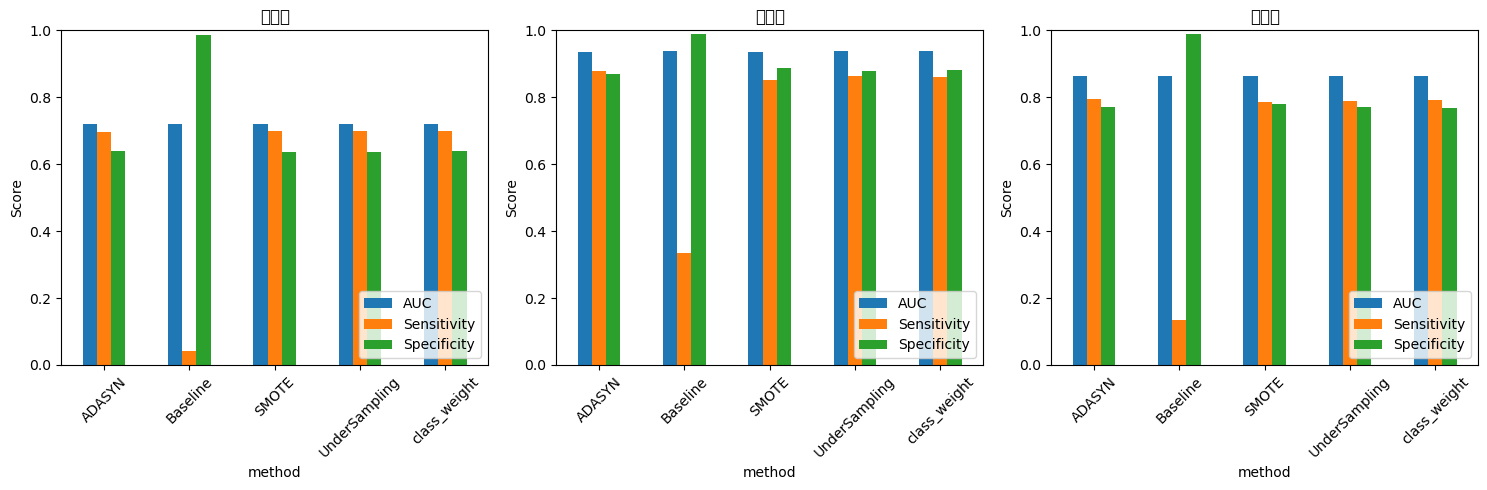

圖表已儲存到 results/smote_comparison.png


In [9]:
# 視覺化比較
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics_to_plot = ['AUC', 'Sensitivity', 'Specificity']

for idx, disease in enumerate(disease_names):
    ax = axes[idx]
    disease_results = results_all[results_all['disease'] == disease]
    
    comparison = disease_results.groupby('method').agg({
        'AUC': 'mean',
        'Sensitivity': 'mean',
        'Specificity': 'mean'
    })
    
    comparison.plot(kind='bar', ax=ax, rot=45)
    ax.set_title(disease)
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig('../../results/smote_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("圖表已儲存到 results/smote_comparison.png")

In [10]:
# 儲存結果
results_all.to_csv('../../results/smote_comparison_results.csv', index=False)
print("結果已儲存到 results/smote_comparison_results.csv")

結果已儲存到 results/smote_comparison_results.csv


## 結論

### 實驗結果

| 方法 | 優點 | 缺點 |
|------|------|------|
| Baseline | - | Sensitivity 低 |
| class_weight | 簡單、有效 | - |
| SMOTE | 生成合成樣本 | 可能過擬合 |
| ADASYN | 關注難分類樣本 | 計算較慢 |
| UnderSampling | 快速 | 丟失資訊 |

### 建議

根據實驗結果，選擇最適合的方法...